### 0. Notebook setup

In [16]:
COLAB = False # Set this to True if you want to install the libraries and clone the repository in Colab
USE_DOTENV = True # Set this to False if you don't have a .env file for storing environment variables

if COLAB:
    USE_DOTENV = False
    dotenv_path = None
    from google.colab import userdata
    colab_secrets = {'HF_TOKEN': userdata.get('HF_TOKEN'), 'HF_TOKEN_WRITE': userdata.get('HF_TOKEN_WRITE')}
    !pip install datasets
    !git clone https://github.com/reddgr/zero-shot-text-classification
    import os
    os.system("mv zero-shot-text-classification zs_tc")

if USE_DOTENV: 
    COLAB=False
    dotenv_path = "../../../../../apis/.env"
    colab_secrets = None

from transformers import pipeline, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification, AutoTokenizer,  AdamW, Trainer, TrainingArguments
import tensorflow as tf
import random
from datasets import load_dataset, Dataset
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
import sys
import os
import torch
import textwrap
from IPython.display import clear_output
import matplotlib.pyplot as plt

if COLAB:
    import sys
    sys.path.append("./zs_tc/src")
    import env_options, nli_labeling_widget as labeling_widget, text_classification_functions as tcf, lmsys_dataset_handler as lmsys
else:
    import sys
    sys.path.append("./src")
    import text_classification_functions as tcf
    import env_options
    import lmsys_dataset_handler as lmsys
    import nli_finetuning_utils

hf_token, hf_token_write, openai_api_key = env_options.check_env(colab=COLAB, use_dotenv=USE_DOTENV, 
                                                 dotenv_path=dotenv_path, colab_secrets=colab_secrets)

Python version: 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
PyTorch version: 2.2.2
Transformers version: 4.44.2
CUDA device: NVIDIA GeForce RTX 4060 Laptop GPU
CUDA Version: 12.1
FlashAttention available: True
Retrieved token(s) from .env file
Using HuggingFace token: hf_M*****************************IASJ
Using HuggingFace write token: hf_u*****************************Xipx
Using OpenAI token: sk-p************************************************************************************************************************************************************_5sA


In [3]:
### DEBUG ###
import importlib
importlib.reload(nli_finetuning_utils)
importlib.reload(tcf)
### DEBUG ###

<module 'text_classification_functions' from 'c:\\Users\\david\\Documents\\git\\zero-shot-text-classification\\./src\\text_classification_functions.py'>

### Loading the Test split of the dataset

In [17]:
test_dataset_dict = load_dataset("reddgr/nli-chatbot-prompt-categorization")
test_dataset = test_dataset_dict["test"]  # Access the "test" split
test_dataset_df = test_dataset_dict["test"].to_pandas()
print("Labels: ",test_dataset_dict["test"].features["label"]._str2int)
entailments_test_dataset_df = test_dataset_df[test_dataset_df['label'] == 2]
display(entailments_test_dataset_df.head(3))
print(f'... {len(entailments_test_dataset_df)} records ...')
display(entailments_test_dataset_df.tail(3))

Labels:  {'contradiction': 0, 'neutral': 1, 'entailment': 2}


,text,category,label
5,I wanna have a conversation in german to practice,language,2
7,What you think about Belarus?,general knowledge,2
9,What does LLaMA means?,technology,2


... 190 records ...


,text,category,label
352,"how can I translate ""self-deprecating"" to Span...",language,2
355,"os.environ[""KERAS_BACKEND""] = ""jax"" # or ""ten...",coding,2
358,The only book I have read by Stanislaw Lem is ...,books,2


## Top-12 categories excluding "general knowledge"

In [18]:
category_counts = entailments_test_dataset_df['category'].value_counts()
top_n_display = 15
print(f'Top {top_n_display} prompt categories:\n{category_counts.head(top_n_display)}')
category_counts = category_counts[category_counts.index != 'general knowledge']
top_n_categories = 12
top_categories = category_counts.head(top_n_categories).index
test_entailments_df = entailments_test_dataset_df[entailments_test_dataset_df['category'].isin(top_categories)]
print(f'{len(test_entailments_df)} records for testing {top_n_categories} categories')
test_entailments_dataset = Dataset.from_pandas(test_entailments_df)
print(test_entailments_dataset)
print(top_categories.to_list())

Top 15 prompt categories:
category
coding               33
technology           26
language             19
writing              19
science              18
business             14
popular culture      11
role play             8
general knowledge     8
riddle                7
finance               5
ai                    4
philosophy            4
images                3
politics              3
Name: count, dtype: int64
168 records for testing 12 categories
Dataset({
    features: ['text', 'category', 'label', '__index_level_0__'],
    num_rows: 168
})
['coding', 'technology', 'language', 'writing', 'science', 'business', 'popular culture', 'role play', 'riddle', 'finance', 'ai', 'philosophy']


Instantiating the zero-shot classifiers:

In [19]:
nli_model_path = 'reddgr/zero-shot-prompt-classifier-bart-ft'
zs_classifier = tcf.ZeroShotClassifier(nli_model_path, nli_model_path, top_categories)

base_model_path = 'facebook/bart-large-mnli'
base_classifier = tcf.ZeroShotClassifier(base_model_path, base_model_path, top_categories)

c:\Users\david\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Zero-shot classification examples:

In [20]:
text_sample = test_entailments_df.sample(1).text.values[0]
# text_sample = "I'm twice the age you were when i was your age. How old are we?"
ft_result = zs_classifier.classify_text(text_sample, multi_label=False)
base_result = base_classifier.classify_text(text_sample, multi_label=False)
clear_output(wait=True)
print("Classification with fine-tuned model:")
for key, value in ft_result.items():
    print(f"{key}: {value}")

print("Classification with base model:")
for key, value in base_result.items():
    print(f"{key}: {value}")

Classification with fine-tuned model:
sequence: Could you define an Interface (class) in c# detailing necessary endpoints for you to interface with?
labels: ['coding', 'technology', 'language', 'writing', 'ai', 'riddle', 'role play', 'business', 'philosophy', 'popular culture', 'science', 'finance']
scores: [0.495, 0.178, 0.084, 0.073, 0.055, 0.036, 0.025, 0.023, 0.012, 0.009, 0.005, 0.004]
Classification with base model:
sequence: Could you define an Interface (class) in c# detailing necessary endpoints for you to interface with?
labels: ['language', 'riddle', 'coding', 'writing', 'technology', 'ai', 'role play', 'business', 'popular culture', 'philosophy', 'finance', 'science']
scores: [0.468, 0.208, 0.122, 0.058, 0.056, 0.038, 0.016, 0.011, 0.009, 0.005, 0.005, 0.004]


In [21]:
df_testing = test_entailments_df.sample(10).copy()
df_testing_zs = zs_classifier.classify_dataframe_column(df_testing, target_column = 'text', feature_suffix = 'zs')
# Add a column to indicate if the prediction was correct
df_testing_zs['is_correct'] = (
    df_testing_zs['category'] == df_testing_zs['top_class_zs']
).astype(int)
# Calculate accuracy of the sample:
sample_accuracy = df_testing_zs['is_correct'].mean() * 100
print(f"Sample accuracy: {sample_accuracy:.1f}%")
display(df_testing_zs)

100%|██████████| 10/10 [00:02<00:00,  4.14it/s]

Sample accuracy: 100.0%


,text,category,label,top_class_zs,top_score_zs,full_results_zs,is_correct
149,You are the text completion model and you must...,coding,2,coding,0.406,"[(coding, 0.406), (technology, 0.201), (ai, 0....",1
196,peripheral neuropathy causes,science,2,science,0.417,"[(science, 0.417), (ai, 0.295), (riddle, 0.051...",1
209,How does the act of selling government bonds r...,finance,2,finance,0.444,"[(finance, 0.444), (science, 0.182), (riddle, ...",1
78,Write a long and detailed fictitious news arti...,writing,2,writing,0.613,"[(writing, 0.613), (role play, 0.14), (busines...",1
242,Any thoughts on criticizing 'the power of veto...,science,2,science,0.285,"[(science, 0.285), (philosophy, 0.228), (ai, 0...",1
55,What's the sum of all integer values from 2 to...,riddle,2,riddle,0.287,"[(riddle, 0.287), (coding, 0.27), (science, 0....",1
108,Check the grammar and improve:,language,2,language,0.504,"[(language, 0.504), (writing, 0.176), (ai, 0.1...",1
285,“Photorealism in CGI has arguably been achieve...,technology,2,technology,0.738,"[(technology, 0.738), (ai, 0.055), (riddle, 0....",1
18,What is the yen carry trade?,finance,2,finance,0.529,"[(finance, 0.529), (business, 0.294), (riddle,...",1
68,please write me python to sort a dictionary by...,coding,2,coding,0.539,"[(coding, 0.539), (technology, 0.259), (writin...",1


Zero-shot classification with facebook/bart-large-mnli: 100%|██████████| 168/168 [00:37<00:00,  4.51it/s]


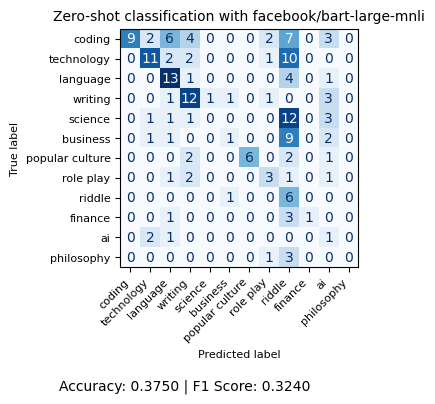

In [22]:
base_test_metrics = base_classifier.test_zs_predictions(test_entailments_df)

Zero-shot classification with reddgr/zero-shot-prompt-classifier-bart-ft: 100%|██████████| 168/168 [00:37<00:00,  4.50it/s]


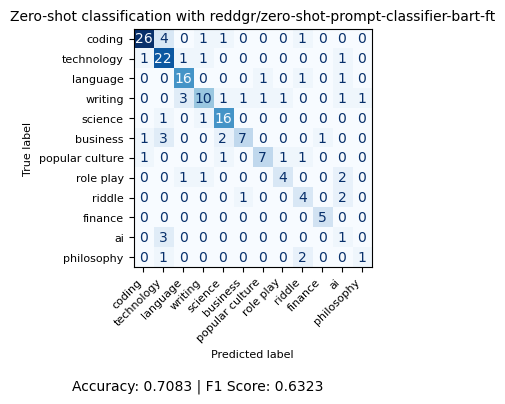

In [23]:
zs_test_metrics = zs_classifier.test_zs_predictions(test_entailments_df)

In [24]:
zs_test_metrics.get('detailed_results')
results_df = pd.DataFrame(zs_test_metrics['detailed_results'])
display(results_df.sample(5))
results_df.to_csv('csv/12c-test.csv', index=False)

,text,category,label,predicted_class
320,"Elaborate more, now based on your own research...",technology,2,technology
327,"now you will place four placeholder texts (""t1...",coding,2,coding
71,Do you know something about british airway?,business,2,science
303,from datasets import load_dataset\ndataset = l...,coding,2,coding
340,"now, after you've created all paragraphs, you'...",coding,2,writing


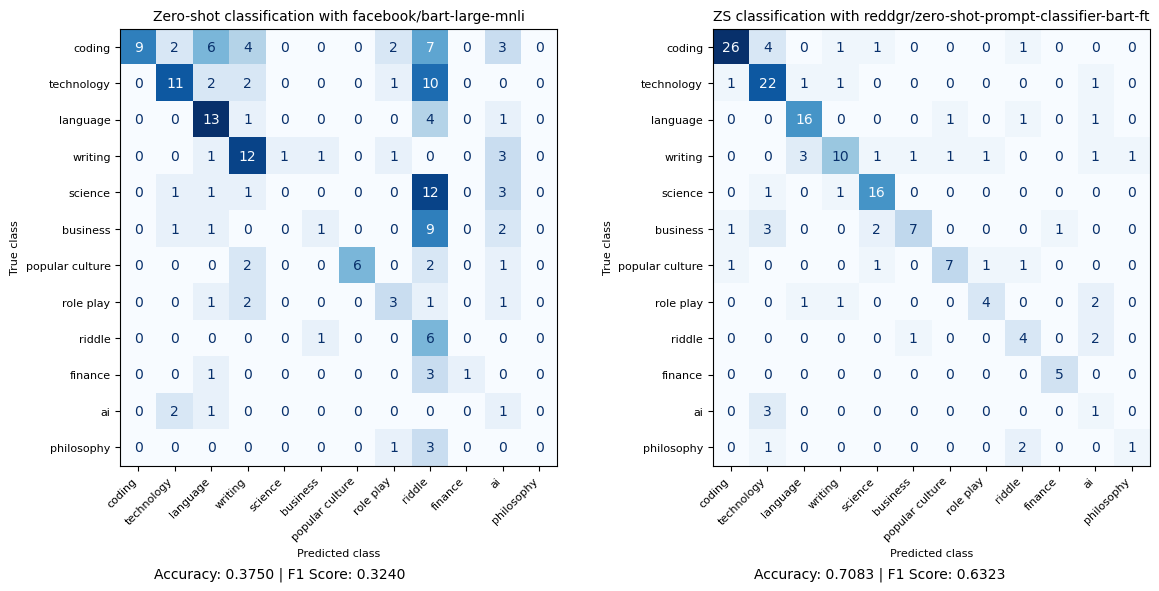

In [25]:
metrics_comp = tcf.MetricsComparison(base_classifier, zs_classifier, base_test_metrics, zs_test_metrics)
metrics_comp.compare_conf_matrices()

In [26]:
zs_test_metrics.get('detailed_results')
results_df = pd.DataFrame(zs_test_metrics['detailed_results'])
results_by_category = results_df.groupby(['category', 'predicted_class']).size().unstack(fill_value=0)
accuracy_by_category = results_df.groupby('category').apply(lambda x: (x['category'] == x['predicted_class']).mean())

print("\nAccuracy by category:")
for category in top_categories:
    print(f"{category:20} {accuracy_by_category[category]:.3f}")

print("\nResults sample:")
display(results_df.sample(5))


Accuracy by category:
coding               0.788
technology           0.846
language             0.842
writing              0.526
science              0.889
business             0.500
popular culture      0.636
role play            0.500
riddle               0.571
finance              1.000
ai                   0.250
philosophy           0.250

Results sample:


,text,category,label,predicted_class
14,can you complete the sentence or make it more ...,language,2,language
173,"Which weighs more, two pounds of feather or on...",riddle,2,riddle
78,Write a long and detailed fictitious news arti...,writing,2,writing
91,"please do the same for Reliance Industries, Al...",business,2,business
72,please provide gnuplot code that will display ...,coding,2,coding


## Top-10 Categories

In [27]:
category_counts = entailments_test_dataset_df['category'].value_counts()
top_n_display = 12
print(f'Top {top_n_display} prompt categories:\n{category_counts.head(top_n_display)}')
category_counts = category_counts[category_counts.index != 'general knowledge']
top_n_categories = 10
top_categories = category_counts.head(top_n_categories).index
test_entailments_df = entailments_test_dataset_df[entailments_test_dataset_df['category'].isin(top_categories)]
print(f'{len(test_entailments_df)} records for testing {top_n_categories} categories')
print(top_categories.to_list())

nli_model_path = 'reddgr/zero-shot-prompt-classifier-bart-ft'
zs_classifier = tcf.ZeroShotClassifier(nli_model_path, nli_model_path, top_categories)

base_model_path = 'facebook/bart-large-mnli'
base_classifier = tcf.ZeroShotClassifier(base_model_path, base_model_path, top_categories)

Top 12 prompt categories:
category
coding               33
technology           26
language             19
writing              19
science              18
business             14
popular culture      11
role play             8
general knowledge     8
riddle                7
finance               5
ai                    4
Name: count, dtype: int64
160 records for testing 10 categories
['coding', 'technology', 'language', 'writing', 'science', 'business', 'popular culture', 'role play', 'riddle', 'finance']


c:\Users\david\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [28]:
base_model_path = 'facebook/bart-large-mnli'
base_classifier = tcf.ZeroShotClassifier(base_model_path, base_model_path, top_categories)
nli_model_path = 'reddgr/zero-shot-prompt-classifier-bart-ft'
zs_classifier = tcf.ZeroShotClassifier(nli_model_path, nli_model_path, top_categories)
base_test_metrics = base_classifier.test_zs_predictions(test_entailments_df, plot_conf_matrix=False)
zs_test_metrics = zs_classifier.test_zs_predictions(test_entailments_df, plot_conf_matrix=False)

Zero-shot classification with facebook/bart-large-mnli: 100%|██████████| 160/160 [07:19<00:00,  2.74s/it]
Zero-shot classification with reddgr/zero-shot-prompt-classifier-bart-ft: 100%|██████████| 160/160 [03:59<00:00,  1.50s/it]


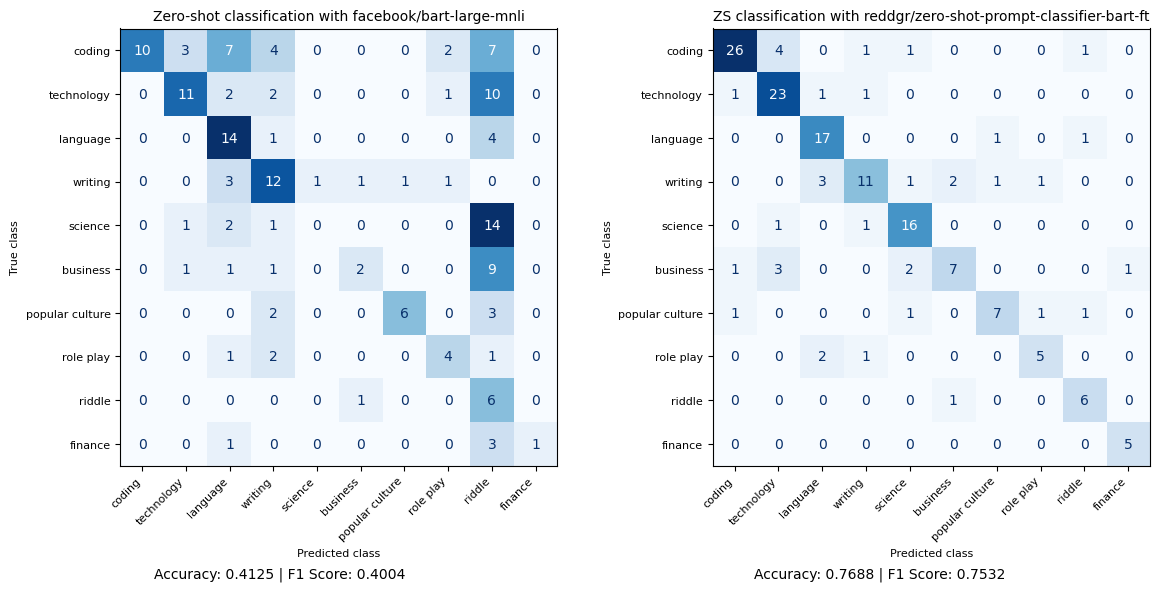

In [29]:
metrics_comp = tcf.MetricsComparison(base_classifier, zs_classifier, base_test_metrics, zs_test_metrics)
metrics_comp.compare_conf_matrices()

In [30]:
zs_test_metrics.get('detailed_results')
results_df = pd.DataFrame(zs_test_metrics['detailed_results'])
results_by_category = results_df.groupby(['category', 'predicted_class']).size().unstack(fill_value=0)
accuracy_by_category = results_df.groupby('category').apply(lambda x: (x['category'] == x['predicted_class']).mean())

print("\nAccuracy by category:")
for category in top_categories:
    print(f"{category:20} {accuracy_by_category[category]:.3f}")

print("\nResults sample:")
display(results_df.sample(5))


Accuracy by category:
coding               0.788
technology           0.885
language             0.895
writing              0.579
science              0.889
business             0.500
popular culture      0.636
role play            0.625
riddle               0.857
finance              1.000

Results sample:


,text,category,label,predicted_class
164,Extract attributes from the product title: NAM...,business,2,coding
86,are you open source?,technology,2,technology
68,please write me python to sort a dictionary by...,coding,2,coding
25,You can make it in CSV format,coding,2,coding
179,I'm twice the age you were when i was your age...,riddle,2,riddle


Riddle example:

In [33]:
# text_sample = test_entailments_df.sample(1).text.values[0]
text_sample = "I'm twice the age you were when i was your age. How old are we?"
ft_result = zs_classifier.classify_text(text_sample, multi_label=False)
base_result = base_classifier.classify_text(text_sample, multi_label=False)
clear_output(wait=True)

print("\nClassification with base model:")
for key, value in base_result.items():
    print(f"{key}: {value}")

print("\nClassification with fine-tuned model:")
for key, value in ft_result.items():
    print(f"{key}: {value}")



Classification with base model:
sequence: I'm twice the age you were when i was your age. How old are we?
labels: ['riddle', 'language', 'role play', 'writing', 'popular culture', 'science', 'business', 'technology', 'finance', 'coding']
scores: [0.515, 0.119, 0.075, 0.073, 0.052, 0.04, 0.039, 0.036, 0.026, 0.026]

Classification with fine-tuned model:
sequence: I'm twice the age you were when i was your age. How old are we?
labels: ['riddle', 'role play', 'science', 'business', 'popular culture', 'writing', 'language', 'finance', 'technology', 'coding']
scores: [0.24, 0.19, 0.101, 0.091, 0.089, 0.067, 0.066, 0.059, 0.055, 0.041]


## 6 TTCB Grouped Categories

In [34]:
test_df_grouped = entailments_test_dataset_df.copy()
# test_df_grouped = test_entailments_df.copy()
test_df_grouped.loc[test_df_grouped['category'] == 'business', 'category'] = 'business and finance'
test_df_grouped.loc[test_df_grouped['category'] == 'finance', 'category'] = 'business and finance'
test_df_grouped.loc[test_df_grouped['category'] == 'language', 'category'] = 'language and writing'
test_df_grouped.loc[test_df_grouped['category'] == 'writing', 'category'] = 'language and writing'
test_df_grouped.loc[test_df_grouped['category'] == 'popular culture', 'category'] = 'culture and entertainment'
test_df_grouped.loc[test_df_grouped['category'] == 'music', 'category'] = 'culture and entertainment'
test_df_grouped.loc[test_df_grouped['category'] == 'entertainment', 'category'] = 'culture and entertainment'
test_df_grouped.loc[test_df_grouped['category'] == 'technology', 'category'] = 'technology and ai'
test_df_grouped.loc[test_df_grouped['category'] == 'ai', 'category'] = 'technology and ai'

In [35]:
category_counts = test_df_grouped['category'].value_counts()
top_n_display = 10
print(f'Top {top_n_display} prompt categories:\n{category_counts.head(top_n_display)}')
category_counts = category_counts[category_counts.index != 'general knowledge']
top_n_categories = 6
top_categories = category_counts.head(top_n_categories).index
test_entailments_grouped = test_df_grouped[test_df_grouped['category'].isin(top_categories)]
print(f'{len(test_entailments_grouped)} records for testing {top_n_categories} category groups')
print(top_categories.to_list())

Top 10 prompt categories:
category
language and writing         38
coding                       33
technology and ai            30
business and finance         19
science                      18
culture and entertainment    13
general knowledge             8
role play                     8
riddle                        7
philosophy                    4
Name: count, dtype: int64
151 records for testing 6 category groups
['language and writing', 'coding', 'technology and ai', 'business and finance', 'science', 'culture and entertainment']


Classifying:

In [36]:
base_classifier = tcf.ZeroShotClassifier('facebook/bart-large-mnli', base_model_path, top_categories)
zs_classifier = tcf.ZeroShotClassifier('reddgr/zero-shot-prompt-classifier-bart-ft', nli_model_path, top_categories)
base_test_metrics = base_classifier.test_zs_predictions(test_entailments_grouped, plot_conf_matrix=False)
zs_test_metrics = zs_classifier.test_zs_predictions(test_entailments_grouped, plot_conf_matrix=False)

c:\Users\david\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Zero-shot classification with facebook/bart-large-mnli: 100%|██████████| 151/151 [00:19<00:00,  7.75it/s]
Zero-shot classification with reddgr/zero-shot-prompt-classifier-bart-ft: 100%|██████████| 151/151 [00:17<00:00,  8.76it/s]


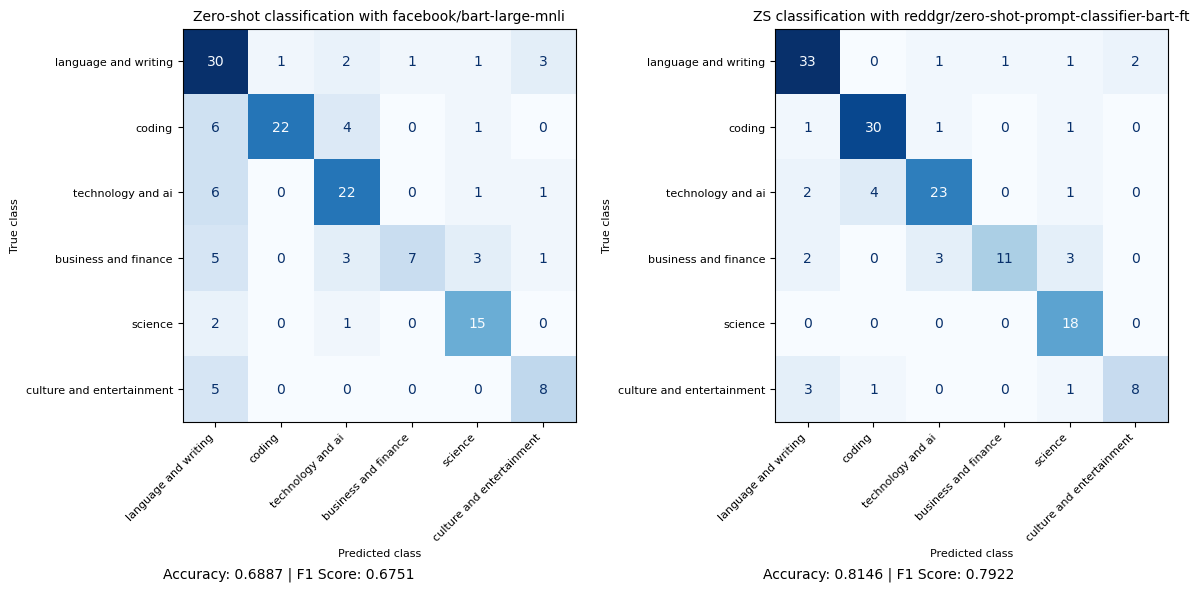

In [37]:
metrics_comp = tcf.MetricsComparison(base_classifier, zs_classifier, base_test_metrics, zs_test_metrics)
metrics_comp.compare_conf_matrices()

______________________________

### Dataset edits

In [3]:
test_dataset_dict = load_dataset("reddgr/nli-chatbot-prompt-categorization")
test_dataset = test_dataset_dict["test"]  # Access the "test" split
test_dataset_df = test_dataset_dict["test"].to_pandas()
print("Labels: ",test_dataset_dict["test"].features["label"]._str2int)
print("Entailments examples:")
display(test_dataset_df[test_dataset_df['label']==2].sample(3))

Labels:  {'contradiction': 0, 'neutral': 1, 'entailment': 2}
Entailments examples:


,text,category,label
145,\nhow to find out my phone number on android?,technology,2
27,Which are some terms to denominate the “west” ...,general knowledge,2
269,whats the miminal ram requirement?,technology,2


In [11]:
text = "recommend a book I read, which I believe people"
test_dataset_df[test_dataset_df['text'].str.contains(text)]

,text,category,label
38,"For today's connection, I want to recommend a ...",role play,0


In [10]:
trxt = "recommend a book I read, which I believe people"
test_dataset_df = test_dataset_df.drop(test_dataset_df[(test_dataset_df['text'].str.contains(text)) 
                                                       & (test_dataset_df['label'] == 2)].index)

In [68]:
text = "This is another headline"
test_dataset_df = test_dataset_df.drop(test_dataset_df[(test_dataset_df['text'].str.contains(text)) 
                                                       & (test_dataset_df['label'] == 2)].index)

test = "because the author also created stories about thinkers from other eras"
test_dataset_df = test_dataset_df.drop(test_dataset_df[(test_dataset_df['text'].str.contains(text)) 
                                                       & (test_dataset_df['label'] == 2)].index)

text = "create an Email alert in snowflake when ever"
test_dataset_df = test_dataset_df.drop(test_dataset_df[(test_dataset_df['text'].str.contains(text)) 
                                                       & (test_dataset_df['label'] == 2)].index)

text = "assist me in composing system architecture"
test_dataset_df = test_dataset_df.drop(test_dataset_df[(test_dataset_df['text'].str.contains(text)) 
                                                       & (test_dataset_df['label'] == 2)].index)

text = "tell a joke about"
test_dataset_df = test_dataset_df.drop(test_dataset_df[(test_dataset_df['text'].str.contains(text)) 
                                                       & (test_dataset_df['label'] == 2)].index)

text = "threatening DMCA takedown notice"
test_dataset_df = test_dataset_df.drop(test_dataset_df[(test_dataset_df['text'].str.contains(text)) 
                                                       & (test_dataset_df['label'] == 2)].index)

In [51]:
text = "sumarize the the answer in a couple"
test_dataset_df.loc[(test_dataset_df['text'].str.contains(text)) 
                    & (test_dataset_df['label'] == 2), 'category'] = 'writing'

text = "correct the spelling for the following text"
test_dataset_df.loc[(test_dataset_df['text'].str.contains(text)) 
                    & (test_dataset_df['label'] == 2), 'category'] = 'writing'

text = "Write below sentence in an alternative way"
test_dataset_df.loc[(test_dataset_df['text'].str.contains(text)) 
                    & (test_dataset_df['label'] == 2), 'category'] = 'writing'

text = "work is a system of inputs that generates wealth for both the business and"
test_dataset_df = test_dataset_df.drop(test_dataset_df[(test_dataset_df['text'].str.contains(text)) 
                                                       & (test_dataset_df['label'] == 2)].index)

text = "but make the responses more succinct and try skipping"
test_dataset_df = test_dataset_df.drop(test_dataset_df[(test_dataset_df['text'].str.contains(text)) 
                                                       & (test_dataset_df['label'] == 2)].index)


text = "discuss your idea to avoid wasting time"
test_dataset_df = test_dataset_df.drop(test_dataset_df[(test_dataset_df['text'].str.contains(text)) 
                                                       & (test_dataset_df['label'] == 2)].index)


text = "This comment was written with ChatGPT assistance"
test_dataset_df = test_dataset_df.drop(test_dataset_df[(test_dataset_df['text'].str.contains(text)) 
                                                       & (test_dataset_df['label'] == 2)].index)

In [12]:
from datasets import Dataset, ClassLabel
test_dataset_new = Dataset.from_pandas(test_dataset_df, preserve_index=False)
print(test_dataset_new)

Dataset({
    features: ['text', 'category', 'label'],
    num_rows: 359
})


In [13]:
label_map = {0: "contradiction",1: "neutral",2: "entailment"}
class_label = ClassLabel(names=[label_map[i] for i in sorted(label_map.keys())])
# Map the 'label' feature to the new ClassLabel feature
def map_labels(example):
    example['label'] = class_label.str2int(label_map[example['label']])
    return example
test_dataset_new = test_dataset_new.map(map_labels)
test_dataset_new = test_dataset_new.cast_column("label", class_label)

Map:   0%|          | 0/359 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/359 [00:00<?, ? examples/s]

In [14]:
test_dataset_new.push_to_hub("reddgr/nli-chatbot-prompt-categorization", token=hf_token_write, split='test')

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/1.30k [00:00<?, ?B/s]

c:\Users\david\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\david\.cache\huggingface\hub\datasets--reddgr--nli-chatbot-prompt-categorization. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


CommitInfo(commit_url='https://huggingface.co/datasets/reddgr/nli-chatbot-prompt-categorization/commit/af4e742a4547c35dabc8152d1cf00c6270b09135', commit_message='Upload dataset', commit_description='', oid='af4e742a4547c35dabc8152d1cf00c6270b09135', pr_url=None, pr_revision=None, pr_num=None)

In [15]:
nli_dataset = load_dataset('reddgr/nli-chatbot-prompt-categorization')
print(f"records in Train split: {len(nli_dataset['train'])}\n...")
display(nli_dataset['train'].to_pandas().tail(3))
print(f"records in Test split: {len(nli_dataset['test'])}\n...")
display(nli_dataset['test'].to_pandas().tail(3))

Generating train split:   0%|          | 0/1437 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/359 [00:00<?, ? examples/s]

records in Train split: 1437
...


,text,category,label
1434,Give At least 4 years of experience a Full s...,business,2
1435,can you suggest a slightly offbeat thing for a...,ai,0
1436,can you suggest a slightly offbeat thing for a...,entertainment,2


records in Test split: 359
...


,text,category,label
356,That’s not how you operate. You are supposed t...,business,0
357,The only book I have read by Stanislaw Lem is ...,science,0
358,The only book I have read by Stanislaw Lem is ...,books,2
